# Compute density from catalog and generate density split catalogs

In [1]:
import math
import numpy as np
import scipy
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import os

from cosmoprimo import fiducial

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from densitysplit import catalog_data, density_split

plots_dir = '/feynman/home/dphp/mp270220/plots/densitysplit'

/feynman/work/dphp/adematti/cosmodesiconda/20240626-1.0.0/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

## Data and output directories

In [3]:
data_dir = '/feynman/scratch/dphp//mp270220/abacus/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [4]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
catalog_name = 'AbacusSummit_2Gpc_z1.175'
#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [5]:
len(catalog.weights)

23463294

## Apply RSD

In [6]:
# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
hz = 100*bg.efunc(catalog.redshift)

catalog.set_rsd(hz=hz)

### Plot halos

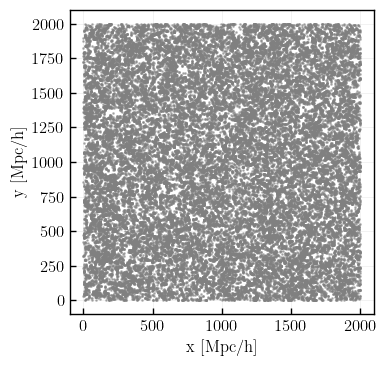

In [7]:
idx=0
cut_direction = 'z'

catalog.show_halos_map(plt.figure(figsize=(4, 4)), plt.gca(), cellsize=10, cut_direction=cut_direction, cut_idx=idx, color='grey')

#plt.suptitle('Cut at '+cut_direction+'={} [Mpc/h]'.format(idx*20))
plt.show()

## Compute density

In [8]:
cellsize = 10
resampler = 'tsc'

# Compute density with weights
catalog_density = density_split.DensitySplit(catalog)
catalog_density.compute_density(data=catalog, cellsize=cellsize, resampler=resampler, use_rsd=True, use_weights=True)
density_with_masses = catalog_density.data_densities

# Compute density without weights
catalog_density.compute_density(data=catalog, cellsize=cellsize, resampler=resampler, use_rsd=True, use_weights=False)
density_without_masses = catalog_density.data_densities

4882.938885625
4882.938885625003
2.93291175
2.932911749999997


### Plot density distribution

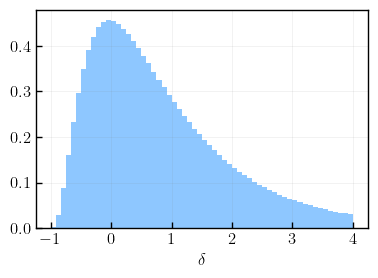

In [9]:
plt.figure(figsize=(4, 3))
plt.hist(density_with_masses, range=(-1, 4), bins=60, density=True, alpha=0.5, label='With halo masses')
#plt.hist(density_without_masses, range=(-1, 4), bins=60, density=True, alpha=0.5, label='Without halo masses')
plt.xlabel("$\delta$")
#plt.ylabel("Normalized counts")
#plt.legend()
plt.show()

### Plot density map

In [10]:
#cmap = plt.get_cmap('coolwarm')
base_colors = ['cornflowerblue', 'red']
cmap = LinearSegmentedColormap.from_list("mycmap", base_colors)

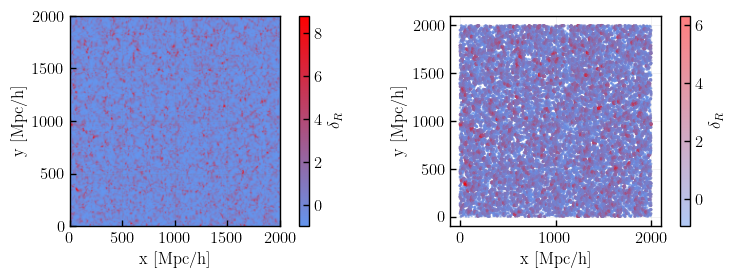

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey = False)

idx=0
cut_direction = 'z'

catalog_density.show_density_map(fig, axes[0], cut_direction=cut_direction, cut_idx=idx, cmap=cmap)
catalog_density.show_halos_map(fig, axes[1], cellsize, positions=catalog.positions, cut_direction=cut_direction, cut_idx=idx, cmap=cmap)

#plt.suptitle('Cut at '+cut_direction+'={} [Mpc/h]'.format(idx*catalog_density.cellsize))
plt.savefig(os.path.join(plots_dir, 'density_map.pdf'), dpi=300)
plt.show()

## Split density

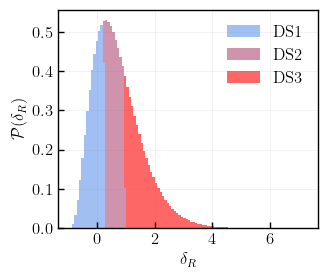

In [13]:
mesh, indices = catalog_density.split_density(3, return_indices=True)
split_densities = [catalog_density.data_densities[indices[i]] for i in range(3)]

#cmap = plt.get_cmap('coolwarm', catalog_density.nsplits)
cmap = LinearSegmentedColormap.from_list("mycmap", base_colors, N=catalog_density.nsplits)
colors = [cmap(i) for i in range(catalog_density.nsplits)]

plt.figure(figsize=(3.5, 3))
plt.hist(split_densities, bins=100, histtype='barstacked', label=['DS{}'.format(i) for i in catalog_density.split_labels], density=True,
         color=colors, alpha=0.6)
plt.xlabel("$\delta_{R}$")
plt.ylabel("$\mathcal{P}(\delta_R)$")
plt.legend()
plt.savefig(os.path.join(plots_dir, 'abacus_densitysplits.pdf'), dpi=300)
plt.show()

### Plot split density map

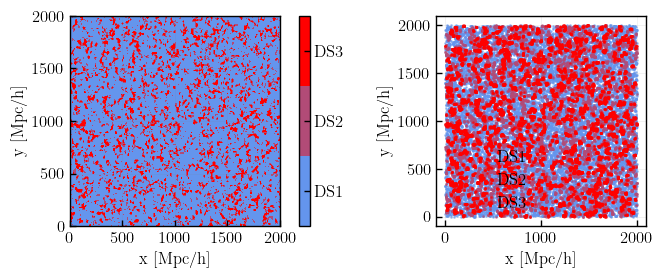

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey = False)

idx=0
cut_direction = 'z'

catalog_density.show_split_density_map(fig, axes[0], cut_direction=cut_direction, cut_idx=idx, show_halos=False, cmap=cmap)
catalog_density.show_halos_map(fig, axes[1], cellsize, cut_direction, cut_idx=idx, positions=catalog.positions, split=True, colors=colors)

axes[1].legend()
#plt.suptitle('Cut at '+cut_direction+'={} [Mpc/h]'.format(idx*catalog_density.cellsize))
plt.savefig(os.path.join(plots_dir, 'density_map_split.png'), dpi=300)
plt.show()

## Generate random catalogs in each split

In [16]:
split_samples = catalog_density.sample_splits(positions='randoms', size=catalog.size, seed=42)

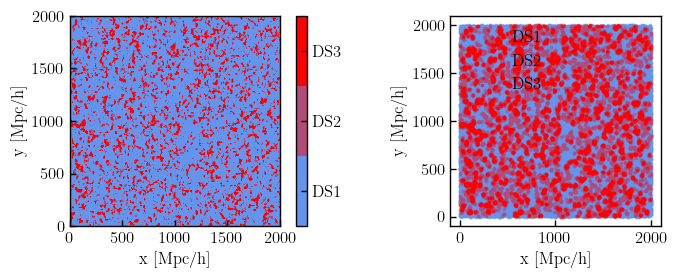

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey = False)

idx=0
cut_direction = 'z'

ax = plt.gca()
catalog_density.show_split_density_map(fig, axes[0], cut_direction=cut_direction, cut_idx=idx, cmap=cmap)
catalog_density.show_randoms_map(fig, axes[1], catalog_density.cellsize, cut_direction=cut_direction, cut_idx=idx, colors=colors)

plt.legend()
#plt.suptitle('Cut at '+cut_direction+'={} [Mpc/h]'.format(idx*catalog_density.cellsize))
plt.show()

In [18]:
# Save Data instance
# catalog_density.save(output_dir+catalog.name+'_density_split')